# W14- Voice of Customer Analytics

Subject: MADT8101-Customer Analytics

Student: Khanistha Paanthag (6420422019)

## Importing libraries and data

In [ ]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn
!pip install deepcut
!pip install pyLDAvis


  Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4


In [ ]:
!pip install --upgrade numba


In [ ]:
!pip install --upgrade --force-reinstall <package_name>


/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `pip install --upgrade --force-reinstall <package_name>'


In [ ]:
import pythainlp
import gensim

import numpy as np
import pandas as pd
import re
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap.umap_ as umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections
import deepcut

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.10/dist-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.10/dist-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

In [ ]:
# ข้อมูลแสดงข้อความที่ถูกพูดถึงใน Social ด้านเศรษฐกิจ (Economy) ปี 2564
df = pd.read_csv('/content/dataload2.csv')
df.tail()

,id,sentence,like_count,published_timestamp,sentiment,sentiment_score,source_type,topic,processed_sentence
94,wj4amEkZ4PI,ชีวิตของแม่ ขึ้นอยู่กับลูก? | Highlight Ep.26 ...,144,2023-07-03T13:00:52Z,NEUTRAL,0.987165,youtube_video,economy.employment,ชีวิต แม่ ขึ้นอยู่กับ ลูก Highlight Ep 26 ดอก ...
95,wHk7b2OnhZo,วิธีสมัครงานโรงแรมคาสิโนมาเก๊าอย่างละเอียด 202...,5,2023-07-01T04:10:38Z,NEUTRAL,0.993337,youtube_video,economy.employment,วิธี สมัครงาน โรงแรม คาสิโน มาเก๊า ละเอียด 202...
96,WE3xxrykGQE,เวลาที่ชาว Bitcoiner รอคอยมาถึงแล้ว? หลังจากผ่...,140,2023-07-06T00:00:13Z,NEUTRAL,0.991666,youtube_video,economy.finance,เวลา Bitcoiner รอคอย มาถึง สถานการณ์ Downtrend...
97,WBZ2WtJ3C4o,คลิปสุดท้ายที่เกาหลี🇰🇷 ลูกครึ่งไทยญี่ปุ่น #ครอ...,180,2023-07-02T15:41:07Z,NEUTRAL,0.955922,youtube_video,economy.tourism,คลิป สุดท้าย เกาหลี 🇰🇷 ลูกครึ่ง ไทย ญี่ปุ่น คร...
98,wBG3NlNQE_g,2Y25 HONDA CR V 2 0 E 4WD โฉมปี 12 17 2014 เต็...,0,2023-07-01T08:15:21Z,NEUTRAL,0.821401,youtube_video,economy.finance,25 HONDA CR WD โฉม ปี 12 17 2014 เต็นท์ รถ ยอด...


In [ ]:
# สร้างไฟล์ CSV จาก DataFrame
#df.to_csv('dataload.csv', index=False , encoding='utf-8-sig')


In [ ]:
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = [' ','  ','\n','(',')','ไทย','ชีวิต','เวลา','ค่ะ','คะ','ๆ','มี','และ','ชีวิต.','สมัครงาน','ๆๆ','ค่','-','ประวัติศาสตร์','ปี','คาสิโน','แม่','นั่ง','คลิป']
screening_words = stopwords + removed_words

existing_words = set(thai_words())
words = {'อุตสาหกรรม','ท่องเที่ยว','เรียนรู้','สงบ','ชุมชน','รัฐบาล','วิสัยทัศน์','รถส่วนตัว','ผู้ประกอบการ','ตำแหน่ง','ข่าว','อีกรอบ','ผู้เชี่ยวชาญ','อพำนวย','สงบดี','วิเคราะห์','คา'}
custom_dict = existing_words.union(words)

custom_dictionary_trie = Trie(custom_dict)

def tokenize_with_comma(sentence):
  merged = ''
  words = pythainlp.word_tokenize(str(sentence), engine = 'newmm',custom_dict = custom_dictionary_trie)
  print(words)
  for word in words:
    if word not in screening_words:
      merged = merged + ',' + word
  return merged[1:]

In [ ]:
import pythainlp
from pythainlp.tokenize import Trie

# Define stopwords and removed words
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = [' ', '  ', '\n', '(', ')', 'ไทย', 'ชีวิต', 'เวลา', 'ค่ะ', 'คะ', 'ๆ', 'มี', 'และ', 'ชีวิต.', 'สมัครงาน', 'ๆๆ', 'ค่', '-', '|', 'ประวัติศาสตร์', 'ปี', 'คาสิโน', 'แม่', 'นั่ง', 'คลิป']
screening_words = stopwords + removed_words

# Define existing words (sample words for demonstration)
existing_words = set(["อุตสาหกรรม", "ท่องเที่ยว", "เรียนรู้", "สงบ", "ชุมชน", "รัฐบาล", "วิสัยทัศน์", "รถส่วนตัว", "ผู้ประกอบการ", "ตำแหน่ง", "ข่าว", "อีกรอบ", "ผู้เชี่ยวชาญ", "อพำนวย", "สงบดี", "วิเคราะห์", "คา"])
words = {'อุตสาหกรรม', 'ท่องเที่ยว', 'เรียนรู้', 'สงบ', 'ชุมชน', 'รัฐบาล', 'วิสัยทัศน์', 'รถส่วนตัว', 'ผู้ประกอบการ', 'ตำแหน่ง', 'ข่าว', 'อีกรอบ', 'ผู้เชี่ยวชาญ', 'อพำนวย', 'สงบดี', 'วิเคราะห์', 'คา'}
custom_dict = existing_words.union(words)

# Create a custom dictionary Trie
custom_dictionary_trie = Trie(custom_dict)

def tokenize_with_comma(sentence):
    merged = ''
    words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
    for word in words:
        if word not in screening_words:
            merged += ',' + word
    return merged[1:]

# Example usage
#sentence = "ต้องการตัดอักขละพิเศษออก ไทย คำ ทดสอบ"
#result = tokenize_with_comma(sentence)
#print(result)



In [ ]:
df['processed_sentence'] = df['sentence'].apply(lambda x: tokenize_with_comma(x))
df.head()

,id,sentence,like_count,published_timestamp,sentiment,sentiment_score,source_type,topic,processed_sentence
0,zzsDOceFRpA,FM 96.5 | ข่าวเด่น ประเด็นร้อน ช่วง Econ plus ...,8,2023-07-01T00:32:45Z,NEUTRAL,0.987861,youtube_video,economy.finance,"FM,96.5,ข่าว,เด่น,ประเด็นร้อน,Econ,plus,หุ้นไท..."
1,ZyfhxEH3Bn4,สรุปข่าวแมนยู ล่าสุด 1 ก.ค. 66 เวลา 08.30 น. -...,1984,2023-07-01T03:36:25Z,NEUTRAL,0.994436,youtube_video,economy.finance,"สรุป,ข่าว,แมนยู,1,ก.ค.,66,08.30,น.,เทนฮากเร่งข..."
2,zy3AVB9nS3E,ชัชชาติ สั่งการทุกเขต ! ตรวจสอบผับ เปิดร้านอาห...,6,2023-07-02T15:08:00Z,NEUTRAL,0.905357,youtube_video,economy.food,"ชัชชาติ,สั่งการทุกเขต,!,ตรวจสอบผับ,เปิดร้านอาห..."
3,zXK4WbwNiU8,ຂ່າວພາກຄໍ່າ [30-06-2023] ຂ່າວພາກຄໍ່າ [30-06-...,15,2023-07-01T00:32:56Z,NEUTRAL,0.985426,youtube_video,economy.retail,"ຂ່າວພາກຄໍ່າ, ,[,30,06,2023,],ຂ່າວພາກຄໍ່າ,[,3..."
4,ZxiQchqn8SY,Highlight : อนาคตของสหภาพยุโรป!! รศ.ดร.สมชาย ภ...,235,2023-07-05T03:25:26Z,NEUTRAL,0.954594,youtube_video,economy.finance,"Highlight,:,อนาคตของสหภาพยุโรป!!,รศ.ดร.สมชาย,ภ..."


In [ ]:
documents = df['processed_sentence'].to_list()
texts = [[text for text in doc.split(',')] for doc in documents]
dictionary = gensim.corpora.Dictionary(texts)
print(dictionary.token2id.keys())

dict_keys(['#', '100', '18.00', '19.30', '30', '66', '96.5', 'Econ', 'FM', 'ThinkingRadio', 'plus', 'ข่าว', 'จุด', 'ติดตามได้ทุกวันจันทร์', 'น.', 'ประเด็นร้อน', 'มิ.ย.', 'รายการ', 'ศุกร์', 'หุ้นไทยตกลง', 'เด่น', '–', '⏰เวลา', '...', '08.30', '1', 'ก.ค.', 'ขอขอบคุณ', 'ขาย?', 'ดึงบิจโลว์(ประตู)', 'ผู้ติดตามทุกท่าน', 'สรุป', 'เทนฮากเร่งขาย!', 'แมนยู', 'โอเซ็มฯถูกเสนอ?', '!', '5', 'กรุงเทพมหานคร', 'คา', 'จะถูกยึดใบอนุญาต', 'ชัชชาติ', 'ดโทษสั่งปิด', 'ตรวจสอบผับ', 'ผับบาร์', 'ภาคค่ำ', 'ยึดใบอนุญาต', 'สั่งการทุกเขต', 'สั่งปิด\xa0', 'เปิดร้านอาหารบังหน้า', 'เร่งตรวจสอบร้านอาหารที่แอบแฝงเปิดเป็นสถานบริการ', '   ', '06', '2023', '[', ']', 'ຂ່າວພາກຄໍ່າ', ':', 'Highlight', 'ภคภาสน์วิวัฒน์.', 'รศ.ดร.สมชาย', 'อนาคตของสหภาพยุโรป!!', '#หุ้นไทย', '19', '63', 'I', 'STARK', 'TNN', 'WEALTH', 'กรรมการผู้จัดการ', 'กับคุณประกิต', 'บลจ.เมอร์ชั่น', 'ปลอมมาตั้งแต่ปี', 'พาร์ทเนอร์', 'สิริวัฒนเกตุ', 'แกะหมายเหตุประกอบงบการเงิน', '13000', '15000', '600', '83000', '@', 'Line', 'Ot', 'id', 'maidnanny', 'จ.ภูเก็ต', '

In [ ]:
num_topics = 500
chunksize = 5000
passes = 500
iterations = 500
eval_every = 5

temp = dictionary[0]
id2word = dictionary.id2token

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import gensim
from gensim import models

# Create gensim_corpus
gensim_corpus = [dictionary.doc2bow(text) for text in texts]

n_topics = 3
model = models.LdaModel(corpus=gensim_corpus, num_topics=n_topics, id2word=id2word, chunksize=chunksize, alpha='auto', eta='auto', iterations=iterations, passes=passes, eval_every=eval_every)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, gensim_corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.119195  0.009470       1        1  42.486648
1      0.050498 -0.097776       2        1  33.415076
0      0.068697  0.088306       3        1  24.098276, topic_info=      Term       Freq      Total Category  logprob  loglift
371      /  13.000000  13.000000  Default  30.0000  30.0000
142    งาน  28.000000  28.000000  Default  29.0000  29.0000
102   เงิน  14.000000  14.000000  Default  28.0000  28.0000
136  สมัคร  11.000000  11.000000  Default  27.0000  27.0000
645    ซ่ง   5.000000   5.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
13    ข่าว   3.427257  20.085821   Topic3  -5.3020  -0.3452
177      ;   2.784629  12.305572   Topic3  -5.5097  -0.0629
5       66   2.784629  12.305572   Topic3  -5.5097  -0.0629
81       .   2.784629  13.065807   Topic3  -5.5097  -0.1229
56      ปี   2.784629  15.920859   Topic3  -5.5097  -0.3205

[195 rows x 6 columns], token_table=      Topic      Freq Term
term                      
174       1  0.809834    "
174       3  0.089982    "
0         1  0.339186    #
0         2  0.211991    #
0         3  0.423982    #
...     ...       ...  ...
391       3  0.759493    系
392       3  0.759493    联
393       1  0.326217    ️
393       2  0.543694    ️
393       3  0.217478    ️

[230 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

## Tokenize Words with pythainlp

In [ ]:
stop_word = list(pythainlp.corpus.thai_stopwords())
rm_word = ['',' ','    ','\n', '(', ')', '?', '+', '--', '//', 'ท่องเที่ยว', '\u200b', 'ๆ(', '..', 'ททท', 'ๆ', 'โรงแรม', '-', '!', "['", "','", 'กระตุ้น', 'เที่ยว',"'", ',', '[', 'คนไทย', 'เพื่อนบ้าน', 'เรื่อง', 'โครงการ', 'ประเทศ']
screenword = stop_word + rm_word

def tokenize_n_space(sentence):
    merged = ''
    words = pythainlp.word_tokenize( str(sentence), engine = 'deepcut')
    for i in words :
        if i not in screenword :
            merged = merged + ',' + i
    return merged[1:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df['tokenized'] = df['sentence'].apply(lambda x: tokenize_n_space(x))
result_df = df.tail(1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


6/6 [==============================] - 0s 20ms/step


In [ ]:
doc = df['tokenized'].to_list()
texts = [ [i for i in dc.split(',')] for dc in doc ]
dictionary = gensim.corpora.Dictionary(texts)


print(dictionary.token2id.keys())

dict_keys(['#', '100', '18.00', '19.30', '30', '66', '96.5', 'Econ', 'FM', 'Radio', 'Thinking', 'plus', '|', 'ข่าว', 'จันทร์', 'จุด', 'ตกลง', 'ติดตาม', 'น.', 'ประเด็น', 'มิ.ย.', 'รายการ', 'ร้อน', 'ศุกร์', 'หุ้น', 'เด่น', 'เวลา', 'ไทย', '–', '⏰', '...', '08.30', '1', 'ก.ค.', 'ขอบคุณ', 'ขาย', 'ข่าวแมนยู', 'ดึง', 'ท่าน', 'บิจโลว์', 'ประตู', 'สรุป', 'เทนฮาก', 'เร่งขาย', 'เสนอ', 'โอเซ็ม', '5', '\xa0', 'กรุงเทพมหานคร', 'คาด', 'ค่ำ', 'ชัชชาติ', 'ตรวจสอบ', 'บริการ', 'บังหน้า', 'บาร์', 'ปี', 'ผับ', 'ยึด', 'ร้าน', 'สถาน', 'สั่ง', 'สั่งการ', 'อนุญาต', 'อาหาร', 'เขต', 'เร่ง', 'แอบแฝง', 'โทษ', 'ใบ', '06', '2023', ']', 'ກ', 'ຂ', 'ຄ', 'ພ', 'ວ', 'າ', '່', 'ໍ', '.', ':', 'Highlight', 'รศ.ดร.สมชาย ภคภาสน์วิวัฒน์', 'สหภาพยุโรป', 'อนาคต', '#หุ้น', '19', '63', 'I', 'STARK', 'TNN ', 'WEALTH', 'กรรมการ', 'คุณประกิต สิริวัฒนเกตุ', 'งบ', 'บ', 'บลจ.เมอร์ชั่น', 'ประกอ', 'ปลอม', 'พาร์ทเนอร์', 'เงิน', 'แกะหมายเหตุ', '*', '13000', '15000', '600', '83000', '@maidnanny', 'Line', 'Ot', 'id', 'กึ่ง', 'จ.ภูเก็ต', 'ต.ตลา

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
gensim_corpus = [ dictionary.doc2bow(tx, allow_update = True) for tx in texts ]
word_frq = [ [ (dictionary[ides], frq) for ides, frq in coup ] for coup in gensim_corpus ]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Topic Modeling - LDA

In [ ]:
num_topic = 5
chunksize = 5000 # size of the doc looked at every pass
passes = 20 # number of passes through documents
iterations = 50
eval_number = 1 # more number, more compute time spending

# Make index to word dictionary
temp = dictionary[0]
id2word = dictionary.id2token

%time
model = gensim.models.LdaModel( corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, alpha='auto', eta='auto'
                               , iterations=iterations, num_topics=num_topic, passes=passes, eval_every=eval_number )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


### Predict Topics

In [ ]:
model.show_topic(0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('...', 0.024181383),
 ('|', 0.01653468),
 ('ซ่ง', 0.010240446),
 ('รัฐบาล', 0.0088186925),
 ('#', 0.00881857),
 ('สมัคร', 0.008811117),
 ('1', 0.008713027),
 ('ไทย', 0.007396202),
 ('รู้', 0.0069624134),
 ('ประธาน', 0.0059740026)]

In [ ]:
model.show_topic(1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('งาน', 0.025323959),
 ('...', 0.014196031),
 ('ไทย', 0.014195824),
 ('สมัคร', 0.0141920475),
 ('.', 0.011410692),
 ('ซ่ง', 0.0100184055),
 ('|', 0.008631529),
 ('เงิน', 0.008626858),
 ('เก๊า', 0.008626843),
 ('บาท', 0.007235943)]

In [ ]:
model.show_topic(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('ข่าว', 0.018250467),
 ('|', 0.01662819),
 ('...', 0.01499547),
 ('66', 0.010105575),
 ('#', 0.010105223),
 ('1', 0.010102118),
 ('າ', 0.010101902),
 ('คน', 0.010100889),
 ('/', 0.008474541),
 ('เวลา', 0.008472979)]

In [ ]:
df['topics'] = df['tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][0])
df['score'] = df['tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][1])
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,sentence,like_count,published_timestamp,sentiment,sentiment_score,source_type,topic,processed_sentence,tokenized,topics,score,KMeans ID,Agglomerative ID
0,zzsDOceFRpA,FM 96.5 | ข่าวเด่น ประเด็นร้อน ช่วง Econ plus ...,8,2023-07-01T00:32:45Z,NEUTRAL,0.987861,youtube_video,economy.finance,"FM,96.5,ข่าว,เด่น,ประเด็นร้อน,Econ,plus,หุ้นไท...","FM,96.5,|,ข่าว,เด่น,ประเด็น,ร้อน,Econ,plus,|,ห...",2,0.996016,0,0
1,ZyfhxEH3Bn4,สรุปข่าวแมนยู ล่าสุด 1 ก.ค. 66 เวลา 08.30 น. -...,1984,2023-07-01T03:36:25Z,NEUTRAL,0.994436,youtube_video,economy.finance,"สรุป,ข่าว,แมนยู,1,ก.ค.,66,08.30,น.,เทนฮากเร่งข...","สรุป,ข่าวแมนยู,1,ก.ค.,66,เวลา,08.30,น.,เทนฮาก,...",2,0.995906,0,0
2,zy3AVB9nS3E,ชัชชาติ สั่งการทุกเขต ! ตรวจสอบผับ เปิดร้านอาห...,6,2023-07-02T15:08:00Z,NEUTRAL,0.905357,youtube_video,economy.food,"ชัชชาติ,สั่งการทุกเขต,!,ตรวจสอบผับ,เปิดร้านอาห...","ชัชชาติ,สั่งการ,เขต,ตรวจสอบ,ผับ,ร้าน,อาหาร,บัง...",4,0.996385,1,0
3,zXK4WbwNiU8,ຂ່າວພາກຄໍ່າ [30-06-2023] ຂ່າວພາກຄໍ່າ [30-06-...,15,2023-07-01T00:32:56Z,NEUTRAL,0.985426,youtube_video,economy.retail,"ຂ່າວພາກຄໍ່າ, ,[,30,06,2023,],ຂ່າວພາກຄໍ່າ,[,3...","ຂ,່,າ,ວ,ພ,າ,ກ,ຄ,ໍ,່,າ,30,06,2023,],ຂ,່,າ,ວ,ພ,າ...",2,0.995092,1,0
4,ZxiQchqn8SY,Highlight : อนาคตของสหภาพยุโรป!! รศ.ดร.สมชาย ภ...,235,2023-07-05T03:25:26Z,NEUTRAL,0.954594,youtube_video,economy.finance,"Highlight,:,อนาคตของสหภาพยุโรป!!,รศ.ดร.สมชาย,ภ...","Highlight,:,อนาคต,สหภาพยุโรป,รศ.ดร.สมชาย ภคภาส...",0,0.977031,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,wj4amEkZ4PI,ชีวิตของแม่ ขึ้นอยู่กับลูก? | Highlight Ep.26 ...,144,2023-07-03T13:00:52Z,NEUTRAL,0.987165,youtube_video,economy.employment,"ชีวิตของแม่,ขึ้นอยู่กับลูก?,Highlight,Ep,.,26,...","ชีวิต,แม่,ลูก,|,Highlight,Ep.,26,ดอก,หญ้า,ป่า,...",3,0.996429,1,0
95,wHk7b2OnhZo,วิธีสมัครงานโรงแรมคาสิโนมาเก๊าอย่างละเอียด 202...,5,2023-07-01T04:10:38Z,NEUTRAL,0.993337,youtube_video,economy.employment,"วิธีสมัครงานโรงแรม,คา,สิโนมาเก๊าอย่างละเอียด,2...","วิธี,สมัคร,งาน,โรงแรมคาสิโนมา,เก๊า,ละเอียด,202...",1,0.994858,1,0
96,WE3xxrykGQE,เวลาที่ชาว Bitcoiner รอคอยมาถึงแล้ว? หลังจากผ่...,140,2023-07-06T00:00:13Z,NEUTRAL,0.991666,youtube_video,economy.finance,"เวลาที่ชาว,Bitcoiner,รอคอยมาถึงแล้ว?,หลังจากผ่...","เวลา,Bitcoiner,รอคอย,สถานการณ์,Downtrend, ฺBit...",1,0.991044,2,0
97,WBZ2WtJ3C4o,คลิปสุดท้ายที่เกาหลี🇰🇷 ลูกครึ่งไทยญี่ปุ่น #ครอ...,180,2023-07-02T15:41:07Z,NEUTRAL,0.955922,youtube_video,economy.tourism,"คลิปสุดท้ายที่เกาหลี🇰🇷,ลูกครึ่งไทยญี่ปุ่น,#ครอ...","คลิป,สุดท้าย,เกาหลี,🇰,🇷,ลูก,ครึ่ง,ไทย,ญี่ปุ่น,...",1,0.990454,1,0


# Document Clustering

In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model
model = hub.load(module_url)

df.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,sentence,like_count,published_timestamp,sentiment,sentiment_score,source_type,topic,processed_sentence,tokenized,topics,score,KMeans ID,Agglomerative ID
94,wj4amEkZ4PI,ชีวิตของแม่ ขึ้นอยู่กับลูก? | Highlight Ep.26 ...,144,2023-07-03T13:00:52Z,NEUTRAL,0.987165,youtube_video,economy.employment,"ชีวิตของแม่,ขึ้นอยู่กับลูก?,Highlight,Ep,.,26,...","ชีวิต,แม่,ลูก,|,Highlight,Ep.,26,ดอก,หญ้า,ป่า,...",3,0.996429,1,0
95,wHk7b2OnhZo,วิธีสมัครงานโรงแรมคาสิโนมาเก๊าอย่างละเอียด 202...,5,2023-07-01T04:10:38Z,NEUTRAL,0.993337,youtube_video,economy.employment,"วิธีสมัครงานโรงแรม,คา,สิโนมาเก๊าอย่างละเอียด,2...","วิธี,สมัคร,งาน,โรงแรมคาสิโนมา,เก๊า,ละเอียด,202...",1,0.994858,1,0
96,WE3xxrykGQE,เวลาที่ชาว Bitcoiner รอคอยมาถึงแล้ว? หลังจากผ่...,140,2023-07-06T00:00:13Z,NEUTRAL,0.991666,youtube_video,economy.finance,"เวลาที่ชาว,Bitcoiner,รอคอยมาถึงแล้ว?,หลังจากผ่...","เวลา,Bitcoiner,รอคอย,สถานการณ์,Downtrend, ฺBit...",1,0.991044,2,0
97,WBZ2WtJ3C4o,คลิปสุดท้ายที่เกาหลี🇰🇷 ลูกครึ่งไทยญี่ปุ่น #ครอ...,180,2023-07-02T15:41:07Z,NEUTRAL,0.955922,youtube_video,economy.tourism,"คลิปสุดท้ายที่เกาหลี🇰🇷,ลูกครึ่งไทยญี่ปุ่น,#ครอ...","คลิป,สุดท้าย,เกาหลี,🇰,🇷,ลูก,ครึ่ง,ไทย,ญี่ปุ่น,...",1,0.990454,1,0
98,wBG3NlNQE_g,2Y25 HONDA CR V 2 0 E 4WD โฉมปี 12 17 2014 เต็...,0,2023-07-01T08:15:21Z,NEUTRAL,0.821401,youtube_video,economy.finance,"2,Y,25,HONDA,CR,V,2,0,E,4,WD,โฉมปี,12,17,2014,...","2,Y,25,HONDA,CR,V,2,0,E,4,WD,โฉม,ปี,12,17,2014...",4,0.996662,0,0


In [ ]:
selected_columns = df[['like_count', 'sentence', 'tokenized', 'topics', 'score']]
selected_columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,like_count,sentence,tokenized,topics,score
0,8,FM 96.5 | ข่าวเด่น ประเด็นร้อน ช่วง Econ plus ...,"FM,96.5,|,ข่าว,เด่น,ประเด็น,ร้อน,Econ,plus,|,ห...",2,0.996016
1,1984,สรุปข่าวแมนยู ล่าสุด 1 ก.ค. 66 เวลา 08.30 น. -...,"สรุป,ข่าวแมนยู,1,ก.ค.,66,เวลา,08.30,น.,เทนฮาก,...",2,0.995906
2,6,ชัชชาติ สั่งการทุกเขต ! ตรวจสอบผับ เปิดร้านอาห...,"ชัชชาติ,สั่งการ,เขต,ตรวจสอบ,ผับ,ร้าน,อาหาร,บัง...",4,0.996385
3,15,ຂ່າວພາກຄໍ່າ [30-06-2023] ຂ່າວພາກຄໍ່າ [30-06-...,"ຂ,່,າ,ວ,ພ,າ,ກ,ຄ,ໍ,່,າ,30,06,2023,],ຂ,່,າ,ວ,ພ,າ...",2,0.995092
4,235,Highlight : อนาคตของสหภาพยุโรป!! รศ.ดร.สมชาย ภ...,"Highlight,:,อนาคต,สหภาพยุโรป,รศ.ดร.สมชาย ภคภาส...",0,0.977031
...,...,...,...,...,...
94,144,ชีวิตของแม่ ขึ้นอยู่กับลูก? | Highlight Ep.26 ...,"ชีวิต,แม่,ลูก,|,Highlight,Ep.,26,ดอก,หญ้า,ป่า,...",3,0.996429
95,5,วิธีสมัครงานโรงแรมคาสิโนมาเก๊าอย่างละเอียด 202...,"วิธี,สมัคร,งาน,โรงแรมคาสิโนมา,เก๊า,ละเอียด,202...",1,0.994858
96,140,เวลาที่ชาว Bitcoiner รอคอยมาถึงแล้ว? หลังจากผ่...,"เวลา,Bitcoiner,รอคอย,สถานการณ์,Downtrend, ฺBit...",1,0.991044
97,180,คลิปสุดท้ายที่เกาหลี🇰🇷 ลูกครึ่งไทยญี่ปุ่น #ครอ...,"คลิป,สุดท้าย,เกาหลี,🇰,🇷,ลูก,ครึ่ง,ไทย,ญี่ปุ่น,...",1,0.990454


In [ ]:
selected_columns.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,like_count,sentence,sentiment_score,tokenized,score
94,144,ชีวิตของแม่ ขึ้นอยู่กับลูก? | Highlight Ep.26 ...,0.987165,"ชีวิต,แม่,ลูก,|,Highlight,Ep.,26,ดอก,หญ้า,ป่า,...",0.996429
95,5,วิธีสมัครงานโรงแรมคาสิโนมาเก๊าอย่างละเอียด 202...,0.993337,"วิธี,สมัคร,งาน,โรงแรมคาสิโนมา,เก๊า,ละเอียด,202...",0.994858
96,140,เวลาที่ชาว Bitcoiner รอคอยมาถึงแล้ว? หลังจากผ่...,0.991666,"เวลา,Bitcoiner,รอคอย,สถานการณ์,Downtrend, ฺBit...",0.991044
97,180,คลิปสุดท้ายที่เกาหลี🇰🇷 ลูกครึ่งไทยญี่ปุ่น #ครอ...,0.955922,"คลิป,สุดท้าย,เกาหลี,🇰,🇷,ลูก,ครึ่ง,ไทย,ญี่ปุ่น,...",0.990454
98,0,2Y25 HONDA CR V 2 0 E 4WD โฉมปี 12 17 2014 เต็...,0.821401,"2,Y,25,HONDA,CR,V,2,0,E,4,WD,โฉม,ปี,12,17,2014...",0.996662


In [ ]:
embed_comments_array = model(df['sentence'].values).numpy()
embed_comments_array

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[ 0.00788704,  0.07477069, -0.00311985, ...,  0.01499981,
         0.01714036,  0.05497692],
       [-0.03658832,  0.03292626,  0.05213334, ..., -0.08318382,
         0.03585595,  0.08483501],
       [-0.05438863,  0.02401441,  0.04928306, ...,  0.01577489,
        -0.01574942, -0.01467302],
       ...,
       [-0.0017032 ,  0.08187176, -0.08521806, ..., -0.02344375,
         0.01588254,  0.0107715 ],
       [-0.04260118,  0.03170208,  0.04318707, ...,  0.0130567 ,
         0.07412528,  0.05673018],
       [-0.03640943,  0.01335024,  0.02214199, ..., -0.06720922,
         0.01311522,  0.00279132]], dtype=float32)

In [ ]:
reducer = umap.UMAP(random_state=42,n_components=20)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## K-means clustering

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'WCSS')

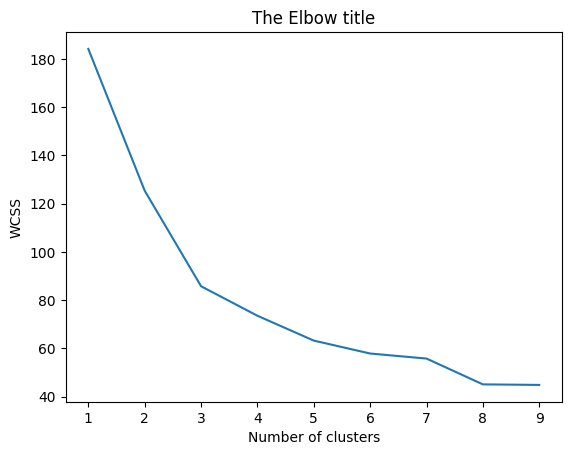

In [ ]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10

for i in range(1, max_k):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(umap_embed_comments_array)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    number_clusters = range(1, max_k)

plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [ ]:
#run kmeans
k = 3
kmeans = KMeans(n_clusters = k, n_init='auto')
kmeans.fit(umap_embed_comments_array)
df['KMeans ID'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#merge all reviews of each cluster into one big sentence
df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])

for i in range(0, k):
    row = []
    row.append(i)
    row.append(df['sentence'][df['KMeans ID'] == i].to_string())
    df_kmeans.loc[len(df_kmeans)] = row

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_kmeans

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,KMeans ID,texts,texts_tokenized,texts_count
0,0,Highlight:อนาคตของสหภาพยุโรป!!รศดรสมชายภเงินหา...,"[:, อนาคต, สหภาพยุโรป, รศด, รสม, ชายภ, เงินหาย...","[(เงิน, 6), (;, 5), (|, 4), (&, 4), (จีน, 4), ..."
1,1,FM|ข่าวเด่นประเด็นร้อนช่วงEconplusสรุปข่าวแมนย...,"[FM, |, เด่น, ร้อน, Econplus, สรุป, แมนยูล่าสุ...","[(|, 8), (;, 6), (เงิน, 3), (quot, 3), (กรกฎาค..."
2,2,ชัชชาติสั่งการทุกเขต!ตรวจสอบผับเปิดร้านอาหຂ່າວ...,"[ชัชชาติ, สั่งการ, เขต, ผับ, ร้าน, อาหຂ, ່, າ,...","[(|, 10), (สมัคร, 8), (າ, 6), (ร้าน, 4), (່, 4..."


In [ ]:
#create regex compiler for removal of a character you don't want
special_characters = "/[!@#$%^&*']/g"
specialchar_pattern = re.compile(special_characters)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#create regex compiler for removal of any emoji
emoji_pattern = re.compile("["
u"\U0001F600-\U0001F64F" # emoticons
u"\U0001F300-\U0001F5FF" # symbols & pictographs
u"\U0001F680-\U0001F6FF" # transport & map symbols
u"\U0001F1E0-\U0001F1FF" # flags (iOS)
"]+", flags=re.UNICODE)

#create regex compiler for removal of digit
number_pattern = re.compile("[0-9]")
#create regex compiler for removal of white space
space_pattern = re.compile("\s+")
#create regex compiler for removal of .
dot_pattern = re.compile(r"\.+")
#create regex compiler for removal of \
backslash_pattern = re.compile(r"\\+")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:12: DeprecationWarning: invalid escape sequence '\s'
<>:12: DeprecationWarning: invalid escape sequence '\s'
<ipython-input-72-1b28a965a998>:12: DeprecationWarning: invalid escape sequence '\s'
  space_pattern = re.compile("\s+")


In [ ]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['',' ','    ','\n', '(', ')', '?', '+', '--', '//', 'Highlight', '\u200b', 'ๆ(', '..', 'ๆๆๆๆ', 'ๆ', 'นะคะ', '-', '!', "['", "','", 'โรงแรม', 'ไทย',"'", ',', '[', 'ตรวจสอบ', 'ข่าว', 'ประเด็น', 'งาน', 'คลิป']
screening_words = stopwords + removed_words

# words = new_words.union(thai_words())
# custom_dictionary_trie = Trie(words)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization
def tokenize_to_list(sentence):
    merged = []
    words = pythainlp.word_tokenize(str(sentence), engine='deepcut')

    for word in words:
        if word not in screening_words:
            merged.append(word)
    return merged

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x:collections.Counter(x).most_common())

 1/45 [..............................] - ETA: 2s

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


39/39 [==============================] - 1s 20ms/step


In [ ]:
df_kmeans

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,KMeans ID,texts,texts_tokenized,texts_count
0,0,Highlight:อนาคตของสหภาพยุโรป!!รศดรสมชายภเงินหา...,"[:, อนาคต, สหภาพยุโรป, รศด, รสม, ชายภ, เงินหาย...","[(เงิน, 6), (;, 5), (|, 4), (&, 4), (จีน, 4), ..."
1,1,FM|ข่าวเด่นประเด็นร้อนช่วงEconplusสรุปข่าวแมนย...,"[FM, |, เด่น, ร้อน, Econplus, สรุป, แมนยูล่าสุ...","[(|, 8), (;, 6), (เงิน, 3), (quot, 3), (กรกฎาค..."
2,2,ชัชชาติสั่งการทุกเขต!ตรวจสอบผับเปิดร้านอาหຂ່າວ...,"[ชัชชาติ, สั่งการ, เขต, ผับ, ร้าน, อาหຂ, ່, າ,...","[(|, 10), (สมัคร, 8), (າ, 6), (ร้าน, 4), (່, 4..."


In [ ]:
# show top key word of each cluster

top_n_words = 10
for i in range(0, len(df_kmeans)):
    print(f"Cluster ID : {i}\n")
    print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_n_words]}\n")

Cluster ID : 0

Most common words include : [('เงิน', 6), (';', 5), ('|', 4), ('&', 4), ('จีน', 4), ('quot', 4), ('หุ้น', 4), ('รัฐบาล', 3), ('ท่องเที่ยว', 3), ('คน', 3)]

Cluster ID : 1

Most common words include : [('|', 8), (';', 6), ('เงิน', 3), ('quot', 3), ('กรกฎาคม', 3), ('ดาว', 3), ('พุธ', 3), ('๔', 3), ('ติดต่อ', 3), ('สื่อสาร', 3)]

Cluster ID : 2

Most common words include : [('|', 10), ('สมัคร', 8), ('າ', 6), ('ร้าน', 4), ('່', 4), ('เด็ด', 3), ('อะเมซิ่ง', 3), ('ลือ', 3), ('EP#taiyang#jploy#', 3), ('เจพลอย', 3)]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 ## cosine similarity clustering

In [ ]:
#clustering using agglomorative clustering
knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(
linkage="average", connectivity=knn_graph, n_clusters=10, metric="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#merge all reviews of each cluster into one big sentence
df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])
for i in range(0, k):
    row = []
    row.append(i)
    row.append(str(df['sentence'][df['Agglomerative ID'] == i].tolist()))
    df_Agglomerative.loc[len(df_Agglomerative)] = row

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#clean and tokenize sentences. count the occurences of each word
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x:
collections.Counter(x).most_common())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4/4 [==============================] - 0s 10ms/step


In [ ]:
#show top keywords of each cluster
top_N_words = 10
for i in range(0, len(df_Agglomerative)):
    print(f"Cluster ID : {i}\n")
    print(f"Most common words include :{list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include :[('|', 56), ('ปี', 21), ('เงิน', 21), ('/', 19), ('"', 18), ('#', 17), ('สมัคร', 17), ('ดู', 16), ('สาย', 16), ('ท่องเที่ยว', 15)]

Cluster ID : 1

Most common words include :[('Clock', 2), ('ทำ', 1), ('กะ', 1), ('ดึก', 1), ('ร้าน', 1), ('สะดวก', 1), ('ซื้อ', 1), ('คน', 1), ('แปลก', 1), ('หน้า', 1)]

Cluster ID : 2

Most common words include :[('nan', 2), (']', 2), ('สวยงาม', 1), ('ดวง', 1), ('ตา', 1), ('สดใส', 1), ('พลายศรีณรงค์', 1), ('ตอน', 1), ('ร้าน', 1), ('ยาย', 1)]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
